### Libraries for LSST cadences extraction

In [24]:

from __future__ import print_function
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.db as db
import pandas as pd
import healpy as hp
from lsst.sims.featureScheduler import utils as schedUtils
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.plots as plots
import lsst.sims.maf.batches as batches
from scipy.stats import binned_statistic
from ipywidgets import widgets
from IPython.display import display


### Functions

In [25]:
# GENRISANJE KRIVE KOJA JE NA 10 GODINA ALI NEPREKIDNA TJ. JEDAN DAN JE KADENCA

def LC_conti(deltatc, long, sigma, tau,  noise=0.05, A=0.2, oscilations=True, P=1000):
    """ 
    Parameters:
    -----------
    deltatc: float or int
        Cadence (time interval between two observations or samplings of the light curve in days).
    long: int
        Duration of the survey in days.
    sigma: float
        Standard deviation for Dumped Random Walk (DRW).
    tau: float or int
        Time lag.
    oscilations: bool, default=True
        If True, light curve simulation will take the oscilatory signal into account.
    P: float or int, default=500
        Period of the oscilatory signal in days.
    A: float or int, default=0.2
        Amplitude of the oscilatory signal in magnitudes.
    noise: float, default=0.05
        Add noise to the simulated light curve.
     
    Returns:
    --------
    yy: np.array
        Obesrved light curve points (Eq. 17 in Kovacevic+2020).
    tt: np.array
        Days during the survey on which we had an observation.
    """
    # Kreiramo array gde imamo vremena (dane) kada je bilo posmatranje. Korak je ustvari kadenca.
    # U slucaju da je kadenca 1, kao sada, onda imamo tt=[0,1,...3650), tj. svaki dan je bilo posmatranje.
    # Malo je nezgodno ako promenimo kadencu posto ce tt biti kraci niz,  a u donjoj for petlji se stavljaju indeksi preko long
    # a to je uvek 10*365. Mada ova funkcija je namenjena u principu samo za kontinualne svetlosne krive.
    a = 5;
    b = a + 5;

    tt = np.arange(0, long, int(deltatc))
    times = tt.shape[0]
    # Tu ce biti light curve points (p_i)
    ss = np.zeros(times)
    # Na prvo mesto u nizu se stavlja jedan broj izvucen iz normalne raspodele (mu=0, sigma).
    ss[0] = np.random.normal(0, sigma, 1)
    # Deo iz Eq (16). Kasnije se koristi kao sigma za izvlacenje iz normalne raspodele.
    ssigma1=sigma*np.sqrt((1-np.exp(-2*deltatc/tau)))
    
    if oscilations == True:
        # kreiraju se arrays duzine 10*365=3650. Svaki clan ima vrednost 0 (za sad)
        # Ovo ce biti poslednji clan Eq (17), gde dobijamo observed light curve.
        # Listamo redom za svaki dan survey-a od 10 godina. Preskace se prvi clan (vec je izvucen iz normalne raspodele).
        sinus=np.zeros(times)
        for i in range(1, times):
            # Deo iz Eq (17) koji opisuje periodicnost. 
            sinus[i]=A*np.sin(2*np.pi*i/P)
            # Eq (16). Generisanje tacaka za svetlosnu krivu. 
            ss[i] = ss[i-1]*np.exp(-deltatc/tau) + np.random.normal(0, ssigma1,1)
            
        # Observed light curve
        yy = np.zeros(times)
        for i in range(times):
            # Eq (17). Generisanje posmatrane svetlosne krive (sa dodatim sumom i sinusnim clanom koji je povezan sa periodom).
            yy[i]=ss[i]+np.random.normal(0,(noise*np.abs(ss[i])),1)+sinus[i]
        
        return yy, tt
    
    
    elif oscilations == False:
        for i in range(1, times): 
            ss[i] = ss[i-1]*np.exp(-deltatc/tau) + np.random.normal(0, ssigma1,1)
        yy=np.zeros(times)
        for i in range(times):
            # Eq (17). Generisanje posmatrane svetlosne krive (sa dodatim sumom i sinusnim clanom koji je povezan sa periodom).
            yy[i]=ss[i]+np.random.normal(0,(noise*np.abs(ss[i])),1)
        
        return yy, tt

        #dtt=[]
        #dyy1=[]
        # i=0 -- i=3648 (shape=3649)
        #for i in range(long-1):
            # j=1 -- j=3649 (shape=3649)
        #    for j in range(i+1,long):
                # Delta tt, dobijamo interval izmedju dva uzastopna merenja. Sada je to uvek 1, ali ne mora biti (zavisi od kadence).
        #       dtt.append(tt[j]-tt[i])
                # Zasto se ovo mnozi??
        #        dyy1.append((yy[j]-yy[i])*(yy[j]-yy[i]))
    
#tceil=np.ceil(mjd-mjd.min()) # Ne bi trebalo ovo da bude ovde?



#SA OVIM IZVLACIMO U OPSIM TRENUCIMA VREDNOSTI KRIVE
def LC_opsim(mjd,t,y):
    """ 
    Parameters:
    -----------
    mjd: np.array
        Modified Julian Date obtained from OpSim. It is the time of each sampling for the light curve.
    t: np.array
        Days during the survey on which we had an observation for continuous simulated light curve (cadence = 1 day).
    y: np.array
        Obesrved light curve points (Eq. 17 in Kovacevic+2020) for continuous simulated light curve (cadence = 1 day).
     
    Returns:
    --------
    top: np.array
        Days during the survey on which we had an observation (sampling) in a given OpSim.
    yop: np.array
        Observed light curve points taken from the continuous light curve on days we had an observation (sampling) in a 
        given OpSim.
    """
    # Racunamo duzinu surveya (ALI SE NE KORISTI NIGDE, izbrisati?)
    long=np.int(mjd.max()-mjd.min()+1)
    
    # np.ceil(x) je najmanji ceo broj i, tako da i>=x.
    # Vremana (dani) kada je bilo posmatranje. Hocemo da mjd pretvorimo u dane posmatranja.
    top=np.ceil(mjd-mjd.min())
    
    # Ovde cemo staviti tacke posmatrane svetlosne krive iz OpSim.
    # Kasnije se t i y koriste iz LC_conti.
    # Mislim da se ovde zapravo gledaju nasa vremena (kadenca = 1 dan) i vremena kada je za datu strategiju iz OpSima moglo
    # da se izvede merenje. Ukoliko se nadje preklapanje dana (a naci ce se, posto imamo simuliranu krivu za svaki dan surveya),
    # za taj dan se uzima merenje (simulirano iz LC_conti). Na taj nacin cemo videti kako razlicite OpSim strategije sampluju 
    # krivu sjaja.
    
    yop=[]
    for i in range(len(top)):
        abs_vals = np.abs(t-top[i])
        bool_arr = abs_vals < 1
        index = (np.where(bool_arr)[0])[0]
        yop.append(y[index])
    yop=np.asarray(yop)
    
    return top,yop
  

def sf(rol1t,rol1):
    """
    Parameters:
    -----------
    rol1t: np.array
        Days during the survey on which we had an observation (sampling) in a given OpSim.
    rol1: np.array
        Observed light curve points taken from the continuous light curve on days we had an observation (sampling) in a 
        given OpSim.

    Returns:
    --------
    srol: np.array
        Mean of the squared flux difference between consecutive light curve points in a bin with edges 
        defined by edgesrol. Used for plotting the y-axis of the structure function visualization.
    edgesrol: np.array
        Bin edges for the range of intervals between consecutive observation times for a given OpSim. Used for plotting the
        x-axis in the structure function visualization.
    """
    # Kasnije se koristi: rol1t = top, rol1 = yop
    #KK=len(rol1t) # broj tacaka (mozda suvisno jer se ponovo definise kasnije, a pre toga se ne koristi)
    dtr=[]
    dy1r=[]
    KK=np.asarray(rol1.shape)[0] # broj opsim tacaka
    for i in range(KK-1):
        dtr.append(rol1t[i+1:KK] - rol1t[i])
        dy1r.append((rol1[i+1:KK] - rol1[i])*(rol1[i+1:KK] - rol1[i]))

    dtr = np.concatenate(dtr, axis=0)
    dy1r = np.concatenate(dy1r, axis=0)
    
    #dtr=np.asarray(dtr)
    #dy1r=np.asarray(dy1r)
    
    # Delimo dtr vrednosti (intervali izmedju uzastopnih vremena posmatranja) na binove i racunamo u svakom binu 
    # srednju vrednost odgovarajucih dy1r vrednosti (kvadrat razlike izmedju uzastopnih vrednosti fluksa svetlosne krive).
    srol, edgesrol, _ = binned_statistic(dtr, dy1r, statistic='mean', bins=np.logspace(0,4,100))
    
    return srol,edgesrol

def LC_SF_viz(deltatc, long, sigma, tau, opsims, labels, A=0.2, noise=0.05,  oscilations=True, P=500):
   
    # Every time the LC_conti function is called, a random simulated light curve is generated. We do this only once because
    # we want to evaluate OpSim light curves on the same referent continuous light curve.
    yy, tt = LC_conti(deltatc, long, sigma, tau, noise, A, oscilations, P)
    
    # Now, we calculate structure function for the continuous light curve.
    
    sc, edgesc = sf(tt, yy)
    
    # We create a figure where all the light curves will be stored.
    fig1 = plt.figure(figsize=(15,10))
    
    # Continuous light curve is plotted first.
    ax11 = fig1.add_subplot(len(opsims)+1,1,1)
    ax11.plot(tt,yy, 'ko', markersize = 1, label='1 day cadence')
    plt.setp(ax11.get_xticklabels(), visible=False)
    custom_xlim = (0, long)
    custom_ylim = (-3.5*A, 3.5*A)
    ax11.set_ylabel('mag [ar.un.]', fontsize = 14)
    ax11.tick_params(direction='in', pad = 5)
    plt.setp(ax11, xlim=custom_xlim, ylim=custom_ylim)
    ax11.legend()
    ax11.grid(True)
    
    # We will store the results from each OpSim light curve and later use those to calculate their structure functions.
    tops = []
    yops = []
    # Now we plot all OpSim light curves that user provided.
    for i, mjd in enumerate(opsims):
        top, yop = LC_opsim(mjd, tt, yy)
        tops.append(top)
        yops.append(yop)
        
        ax = fig1.add_subplot(len(opsims)+1,1,i+2)
        ax.plot(top, yop, 'ko', markersize = 1, label='%s' %labels[i])
        
        if (i+1) == len(opsims):
            ax.set_xlabel('t [days]', fontsize=14)
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
    
        ax.set_ylabel('mag [ar.un.]', fontsize = 14)
        ax.tick_params(direction='in', pad = 5)
        plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
        ax.legend()
        ax.grid(True)    
    
    tops = np.asarray(tops)
    yops = np.asarray(yops)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)
    fig1.suptitle('Light curves', y=0.92, fontsize=17)
    
    plt.show()
    
    
    # We create a second figure to store structure function plots.
    fig2 = plt.figure(figsize=(15,6))
    # First, we plot the structure function of the continuous light curve.
    ax21 = fig2.add_subplot(121)
    ax21.plot(np.log10(edgesc[:-1]+np.diff(edgesc)/2), np.log10(np.sqrt(sc)), 'ko-',linewidth=1, markersize=3,label='1 day cadence')
    ax21.set_xlabel(r'$\log_{10}(\Delta t)$', fontsize = 14)
    ax21.set_ylabel(r'$\log_{10} \ SF$', fontsize = 14)
    
    ax22 = fig2.add_subplot(122)
    ax22.plot(np.log10(edgesc[:-1]+np.diff(edgesc)/2), np.sqrt(sc), 'ko-',linewidth=1, markersize=3,label='1 day cadence')
    ax22.set_xlabel(r'$\log_{10}(\Delta t)$', fontsize = 14)
    ax22.set_ylabel('SF', fontsize = 14)
    
    # We now plot the structure functions of OpSim light curves over the structure function of the continuous light curve.
    color=iter(plt.cm.cool(np.linspace(0,1,len(opsims))))
    i = 0 # counter
    for topp, yopp in zip(tops, yops):
        s, edge = sf(topp, yopp)
        c=next(color)
        ax21.plot(np.log10(edge[:-1]+np.diff(edge)/2), np.log10(np.sqrt(s)), c=c, linewidth=1, marker='o', markersize=3, label='%s'%labels[i])
        ax22.plot(np.log10(edge[:-1]+np.diff(edge)/2), np.sqrt(s), c=c, linewidth=1, marker='o', markersize=3, label='%s'%labels[i])
        i = i+1
    
    axs = [ax21, ax22]
    
    for ax in axs:
        ax.tick_params(direction='in', pad = 5)
        ax.legend()
        ax.grid(True)
        
    fig2.suptitle('Structure functions', y=0.96, fontsize=17)
    #fig2.show()
    
    
# get opsim cadence file
def getOpSimCadence(opsim, name, ra = 0, dec = 0, fil = 'r'):
    
    # We are only interested in date of observation for chosen filter and field point
    colmn = 'observationStartMJD';
    
    # Directory where tmp files are going to be stored
    outDir = 'TmpDir'
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # Using MAF PassMetrics to get all desired data from the chosen opsim realisation
    metric=metrics.PassMetric(cols=[colmn,'fiveSigmaDepth', 'filter'])
    
    # Select RA and DEC
    slicer = slicers.UserPointsSlicer(ra=ra,dec=dec)
    
    # Add sql constraint to select desired filter
    sqlconstraint = 'filter = \'' + fil + '\''
    
    
    # Run simulation
    bundle = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint, runName=name)
    bgroup = metricBundles.MetricBundleGroup(
        {0: bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
    bgroup.runAll();
    filters = np.unique(bundle.metricValues[0]['filter'])
    mv = bundle.metricValues[0]
    
    
    # Get dates
    mjd = len(mv[colmn])
    
    # Out file
    filepath = name + "_" + str(ra) + "_" + str(dec) + "_" + fil +".dat";
    with open(filepath, 'w') as file_handler:
        for item in mv[colmn]:
            file_handler.write("{}\n".format(item))

    mjd=np.loadtxt(filepath)
    mjd=np.sort(mjd)
    
    return mjd;

### Chose init data 
### Constants

In [34]:
# mjd_array = []
# opsim = []

In [35]:

# HTML for filters
# This part of the code is for choosing only
def select_data_filters(data):
    # scFilter.options = filters[data]
    print(data)
    
filters={'g':'g','r':'r', 'u':'u', 'z':'z'}
scFilter = widgets.Select(options=filters.keys())
init = scFilter.value
i = widgets.interactive(select_data_filters, data=scFilter)
print('Choose filter: ');
display(i)

# Choose OpSim Realisation
opsims = {
    'FBS 1.5: AGN DDF' : 'agnddf_v1.5_10yrs.db',
    'FBS 1.5: BASELINE' : 'baseline_v1.5_10yrs.db',
    'FBS 1.5: ROLLING MOD 6' : 'rolling_mod6_sdf_0.20_v1.5_10yrs.db'
}
scOpSims = widgets.Select(options=opsims.keys())
init2 = scOpSims.value

def select_data_opsims(data):
    print(data)
    # scOpSims.options = opsims[data]

j = widgets.interactive(select_data_opsims, data=scOpSims)
print('Choose opsims: ');
display(j)



# Choose RA
print('Choose RA:')
scRa = widgets.Text(placeholder="Right accension");
display(scRa);

# Choose DEC
print('Choose DEC:')
scDec = widgets.Text(placeholder="Declination");
display(scDec);

#Choose noise
print ('Choose Noise:');
def select_data_noise(data):
    # cityW.options = noises[data]
    print(data);
noises={'1%':'0.01','2%':'0.02', '5%':'0.05', '10%':'0.1'}
scNoises = widgets.Select(options=noises.keys())
init3 = scNoises.value
k = widgets.interactive(select_data_noise, data=scNoises)
display(k)

np.random.seed(0)
sigma=0.18/np.sqrt(2) # standard deviation for DRW
tau=500. # time lag
long=10*365 # survey duration in days
deltatc=1. # cadence for LC_conti



#Choose amplitude
print('Choose amplitude:')
scAmp = widgets.Text(placeholder="Amplitude", value="0.2");
display(scAmp);



Choose filter: 


interactive(children=(Select(description='data', options=('g', 'r', 'u', 'z'), value='g'), Output()), _dom_cla…

Choose opsims: 


interactive(children=(Select(description='data', options=('FBS 1.5: AGN DDF', 'FBS 1.5: BASELINE', 'FBS 1.5: R…

Choose RA:


Text(value='', placeholder='Right accension')

Choose DEC:


Text(value='', placeholder='Declination')

Choose Noise:


interactive(children=(Select(description='data', options=('1%', '2%', '5%', '10%'), value='1%'), Output()), _d…

Choose amplitude:


Text(value='0.2', placeholder='Amplitude')

### Read Params

In [36]:
fil = scFilter.value;
opsim = opsims[scOpSims.value];

if not scRa.value or len(scRa.value) == 0 :
    ra = 0;
else:
    ra = int(scRa.value)

if not scDec.value or len(scDec.value) == 0 :
    dec = np.radians(-30);
else:
    ra = np.radians(int(scDec.value));

    
noise = float(noises[scNoises.value]);
amp = float(scAmp.value);

# get opsim path
dbfile = '/home/idies/workspace/lsst_cadence/FBS_1.5/' + opsim;
outDir = '../tmp/'
opsdb = db.OpsimDatabase(dbfile)



### A bit of plotting 

HealpixSubsetSlicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'fieldRA', 'observationStartMJD'].
Found 2180601 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
monopole: 987.361  dipole: lon: 40.1155, lat: -23.7511, amp: 43.4538


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 5488 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


{'SkyMap': 3, 'Histogram': 4, 'PowerSpectrum': 5}

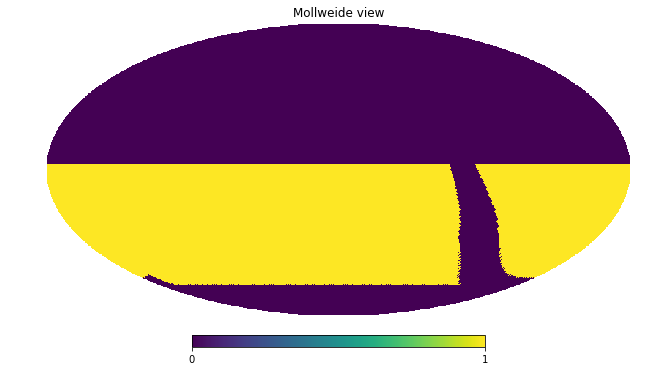

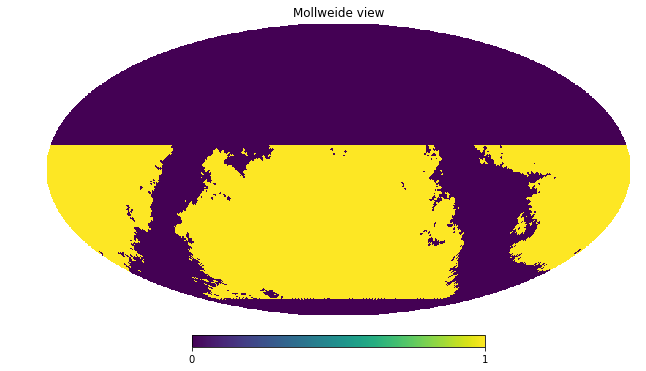

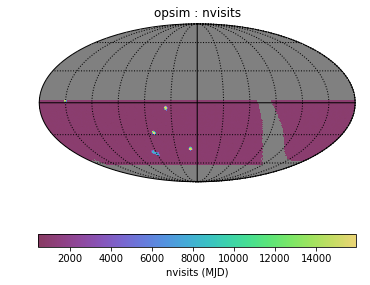

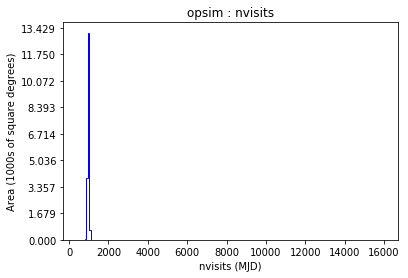

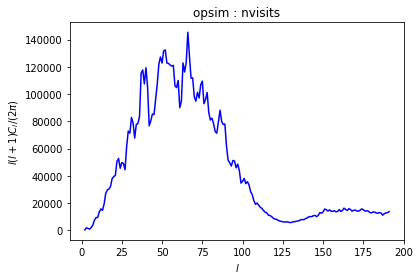

In [38]:

# Let's count the visits .. 
metric = metrics.CountMetric('observationStartMJD', metricName='nvisits')

# .. over the WFD region - so define the WFD footprint first.
nside = 64
wfd_standard = schedUtils.WFD_no_gp_healpixels(nside, dec_max=2.5, dec_min=-62.5)
wfd_bigdust = schedUtils.WFD_no_dust_healpixels(nside, dec_max=12.25, dec_min=-72.5, dust_limit=0.19)
hp.mollview(wfd_standard)
hp.mollview(wfd_bigdust)
# we'll use the standard WFD here, as that is what was used with the baseline.
slicer = slicers.HealpixSubsetSlicer(nside, np.where(wfd_standard==1)[0])

# And we will skip DD visits, so add a constraint to avoid them.
constraint = 'note not like "DD%" and  filter = \'' + fil + '\'';
bundle = mb.MetricBundle(metric, slicer)
g = mb.MetricBundleGroup({'0': bundle}, opsdb, outDir=outDir)
g.runAll()
bundle.plot()

### Get cadences

In [7]:
# Start everything

mjd =  getOpSimCadence(opsdb, opsim, ra, dec, fil);
LC_SF_viz(deltatc, long, sigma, tau, [mjd], [opsim], noise, amp);

NameError: name 'metricBundles' is not defined